In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [2]:
%autosave 0
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import torch

Autosave disabled


# *Deep Reinforced Learning*

Hoy en día el estado del arte en el reconocimiento de patrones está dominado por las **redes neuronales profundas**

- Visión Computacional: Redes Neuronales Convolucionales, Adversarios generativos
- Reconocimiento de habla: Redes Recurrentes, WaveNet
- Procesamiento de lenguaje Natural: Transformers

> Podemos aprovechar la habilidad de las redes profundas para representar el mundo para diseñar mejores algoritmos de aprendizaje reforzado


En base a redes profundas se han obtenido algoritmos de aprendizaje reforzado con desempeño muy superior a Q-Learning: **Deep RL**

> Aprovechar la habilidad de las redes neuronales de representar el mundo: modelos


# Value Learning

En este tipo de algoritmos usamos un política de máxima utilidad para escoger acciones

$$
\pi^*(s) = \text{arg} \max_{a\in \mathcal{A}} Q(s, a)
$$

Y el problema entonces se reduce a aprender **Q**, *e.g* Q-Learning

Sin embargo Q-learning tiene limitaciones: 
- requiere de heurísticas para explorar 
- espacio de acciones debe ser discreto
- espacio de estados debe ser discreto

De hecho el estado no puede ser demasiado grande, como veremos a continuación

#### Ambiente: [Space invaders](https://es.wikipedia.org/wiki/Space_Invaders)

Originalmente un juego de Arcade lanzando en 1978, en 1980 tuvo una versión para ATARI 2600

> El objetivo es derrivar a los extraterrestres usando un cañon antes de que desciendan a la Tierra

- El cañon puede moverse a la izquierda, a la derecha y disparar
- Hay cuatro escudos con los que el cañon puede protegerse de los disparos enemigos
- Mientras menos enemigos más rápido se mueven

In [ ]:
import gym
from time import sleep

env = gym.make("SpaceInvaders-v0") 
env.reset()
end = False

while not end:
    a = env.action_space.sample()
    s, r, end, info = env.step(a)
    env.render() 
    sleep(.02)     

In [ ]:
env.close()

In [ ]:
# Espacio de estados
display(env.observation_space)
# Espacio de acciones
display(env.action_space)
display(env.action_space.n)
display(env.env.get_action_meanings())

Por ejemplo si usaramos un stack de 4 imágenes consecutivas como estado y asumiendo que cada pixel tiene 255 niveles:

In [ ]:
255**(210*160*4*3)

Claramente, llenar una tabla Q con esta cantidad de estados no es práctico

# Deep Q-Network (DQN) 

Propuesto en [(Minh et al. 2013)](https://arxiv.org/abs/1312.5602)

#### Idea clave

> Se puede usar una red convolucional como representación del estado (mundo)

- La entrada de la red neuronal es el estado $s$, el estado puede ser continuo o discreto
- La salida de la red neuronal son los valores $Q(s, a_1), Q(s, a_2), \ldots, Q(s, a_N)$

> Ya no es necesario mantener una tabla Q que crece con el número de estados

Sin embargo aun requerimos que le espacio de acciones sea discreto


Esto se conoce como **Deep Q-Network** y es un tipo de value-learning

(Previamente se usaba una red que recibe $s$ y $a$ y retorna $Q(s,a)$, ¿por qué lo expuesto arriba es superior?)


#### Función de pérdida (loss)

La función de perdida que se ocupa en DQN es el error cuadrático medio entre la ecuación de Bellman y la predicción de la red

$$
\mathcal{L}(\theta) = \mathbb{E}\left[\left \| R(s,a) + \gamma \max_{a' \in \mathcal{A}} Q_\theta(s', a') - Q_\theta(s, a)\right \|^2\right]
$$

Recordemos: $s'$ es el estado al que llegamos luego de ejecutar $a$ sobre $s$

**Double DQN:** Usar redes neuronales distintas para la predicción y el objetivo tiende a reducir el sesgo en que incurre la red en las primeras iteraciones

$$
\mathcal{L}(\theta, \phi) = \mathbb{E}\left[\left \| R(s,a) + \gamma \max_{a' \in \mathcal{A}} Q_\phi(s', a') - Q_\theta(s, a)\right\|^2\right]
$$

#### Trucos

Para mejorar la estababilidad del entrenamiento se propone lo siguiente:

#### Experience Replay

Consiste en almacenar conjuntos de estados, acciones y recompensas consecutivas

Luego se crean mini-batches a partir de ellos


[DQN alcanza destreza sobre-humana en 50 juegos de ATARI sin conocimiento a priori](https://deepmind.com/blog/article/deep-reinforcement-learning)

# DQN para el carro con péndulo

Previamente fue necesario discretizar el estado para construir la matriz Q

En DQN podemos obviar este paso y sus complicaciones

In [13]:
class DQN_pole(torch.nn.Module):
    
    def __init__(self, n_hidden=10):
        super(DQN_pole, self).__init__()
        self.linear1 = torch.nn.Linear(4, n_hidden)
        self.linear2 = torch.nn.Linear(n_hidden, n_hidden)
        self.linear3 = torch.nn.Linear(n_hidden, 2)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        h = self.activation(self.linear1(x))
        h = self.activation(self.linear2(h))
        return  self.linear3(h)

<IPython.core.display.Javascript object>


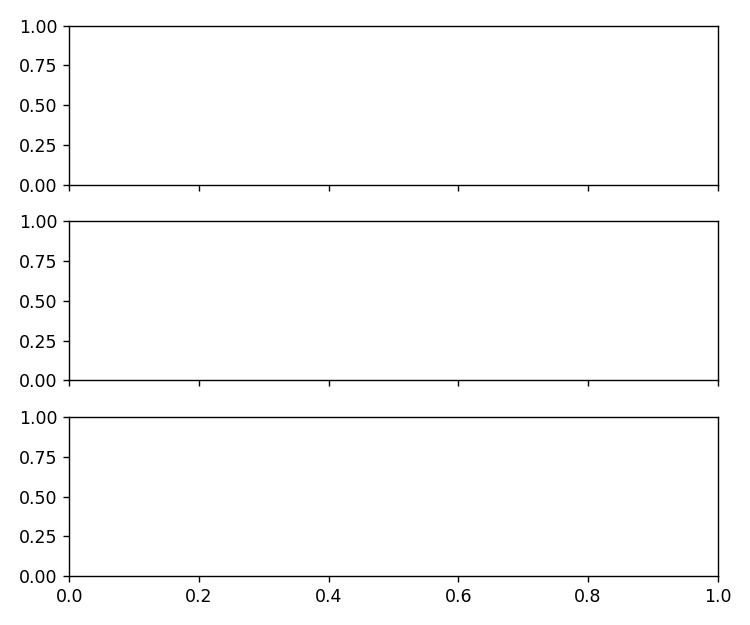

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize=(6, 5), sharex=True, tight_layout=True)

def update_plot():
    for ax_ in ax:
        ax_.cla()
    
    episodes = np.arange((episode+1)//100)*100
    ax[0].errorbar(episodes,
                   np.array(diagnostics['rewards']).mean(axis=1), 
                   np.array(diagnostics['rewards']).std(axis=1));
    ax[0].set_ylabel('Recompensa\npromedio');
    ax[1].errorbar(episodes,
                   np.array(diagnostics['episode_length']).mean(axis=1), 
                   np.array(diagnostics['episode_length']).std(axis=1));
    ax[1].plot(episodes, [195]*len(episodes), 'k--')
    ax[1].set_ylabel('Largo promedio\nde los episodios');
    ax[2].plot(episodes, epsilon(episodes))
    ax[2].set_ylabel('Epsilon')
    ax[2].set_xlabel('Episodios')
    fig.canvas.draw()

In [25]:
import numpy as np
import gym
from tqdm.notebook import tqdm

env = gym.make("CartPole-v0")

model_Q = DQN_pole() # NUEVO
optimizer = torch.optim.Adam(model_Q.parameters(), lr=1e-3)

diagnostics = {'rewards': [], 'episode_length': []}
# Parametros
alpha = lambda episode: 0.1
#alpha = lambda episode: 0.01 + (1. - 0.01) * np.exp(-epsilon_rate*episode) 
gamma = 0.999
epsilon_init = 1.0 
epsilon_end = 0.01 
epsilon_rate = 1e-3
epsilon = lambda episode : epsilon_end + (epsilon_init - epsilon_end) * np.exp(-epsilon_rate*episode) 

for episode in tqdm(range(3000)):
    env.reset()
    end = False
    # Entrenamiento
    while not end:        
        s_current = torch.from_numpy(np.array(env.state).astype('float32')) # NUEVO
        # Seleccionar la acción
        if not np.random.binomial(1, p=1.-epsilon(episode)): 
            Q_present = model_Q(s_current) # NUEVO
            a = Q_present.argmax().detach().numpy() # NUEVO        
        else:
            a = env.action_space.sample() 
        # Ejecutarla
        s, r, end, info = env.step(a)
        s_future = torch.from_numpy(np.array(s).astype('float32')) # NUEVO
        # Actualizar Q
        #Q[s_current][a] += alpha(episode)*(r + gamma*np.max(Q[s_future]) - Q[s_current][a]) 
        loss = (r + gamma*model_Q(s_future).max() - Q_present.max())**2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Prueba
    # Cada 100 epocas evaluamos nuestro agente
    if np.mod(episode+1, 100) == 0:
        diagnostics['rewards'].append(np.zeros(shape=(10,)))
        diagnostics['episode_length'].append(np.zeros(shape=(10,)))
        for k in range(10):
            env.reset()    
            end = False
            episode_length = 0
            episode_reward = 0.0
            while not end:        
                s_current = torch.from_numpy(np.array(env.state).astype('float32')) 
                a = model_Q(s_current).argmax().detach().numpy() 
                s_future, r, end, info = env.step(a)
                episode_length += 1
                episode_reward += r
            
            diagnostics['rewards'][-1][k] = episode_reward
            diagnostics['episode_length'][-1][k] = episode_length
        update_plot()

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

### Policy learning

Find $\pi(s)$, sample $a\sim\pi(s)$

Neural network that recieves a state and returns $P(a_1|s), P(a_2|s), \ldots, P(a_N|s)$. You draw a sample from this distribution

advantages? distribution does not need to be categorical, can handle continuous, parametrize $\mu$ and $\sigma$ 


Training algorithm

- Run policy until termination, record tuples actions/states/rewards
- Decrease pbb of actions that ended on low reward 
- Increase pbb of actions that ended on high reward

$$
L = - \log P(a_t|s_t) R_t
$$

log likelihood of selecting the action, how likely was this action that you selected

total discounted returned recieved by selecting that action

- high reward times likely action -> desirable, will not change
- reward is low times likely action -> undesirable, will minimize: remove pbb of this action

$$
w = w + \mu \nabla \log P(a_t|s_t) R_t
$$

policy gradient


https://medium.com/@curiousily/solving-an-mdp-with-q-learning-from-scratch-deep-reinforcement-learning-for-hackers-part-1-45d1d360c120

https://github.com/aamini/introtodeeplearning/blob/master/lab3/RL.ipynb


real life: run until termination!!!!! Requires simulator!!!!
- realistic simulation + transfer learning
- real world observations + one shot trial & error


- https://arxiv.org/abs/1811.12560
- https://pathmind.com/wiki/deep-reinforcement-learning    
- https://towardsdatascience.com/why-going-from-implementing-q-learning-to-deep-q-learning-can-be-difficult-36e7ea1648af   
https://towardsdatascience.com/policy-based-reinforcement-learning-the-easy-way-8de9a3356083

- https://github.com/deepmind/pysc2
- http://chris-chris.ai/2017/08/30/pysc2-tutorial1/
- https://github.com/chris-chris/pysc2-examples
- https://blog.goodaudience.com/lessons-and-mistakes-from-my-first-reinforcement-learning-starcraft-agent-4245cc35e956
- https://faculty.utrgv.edu/dongchul.kim/csci4352/spring2019/report/R5.pdf
- http://courses.cecs.anu.edu.au/courses/CSPROJECTS/19S1/reports/u6049249_report.pdf
- https://chatbotslife.com/building-a-smart-pysc2-agent-cdc269cb095d